### Script that increase the FlowRateIn every 90 seconds with 300 L/s and display the Bottom Hole Pressure

In [1]:
import openlab
import matplotlib.pyplot as plt
import numpy
import time
import pandas as pd
import time
import random
import pprint as pr
import datetime
import os
import subprocess

In [2]:
config_name = "InclinedWell"
sim_name = "validation"
initial_bit_depth = 2500

In [3]:
username=
apikey=
licenseguid=

session = openlab.http_client(username=username, apikey=apikey,licenseguid=licenseguid) #this initializes an http client that can be used for an entire openlab session

11:15:47 [INFO] Initializing Openlab http client
11:15:47 [INFO] Creating token
11:15:47 [INFO] Saving token
11:15:47 [INFO] Login Succesfull


In [4]:
sim = session.create_simulation(config_name, sim_name, initial_bit_depth)

11:15:51 [INFO] User limits: {'ActiveSimulationCount': 2, 'MaxConcurrentSimulations': 5, 'MaxSimulationCount': 0, 'MaxStepCount': 180000, 'MaxStoredSimulations': 10, 'MaxTimeStep': 18000, 'TotalSimulationCount': 1737, 'UsedCapacityPercent': 20, 'UsedStepCount': 35379}
11:15:52 [INFO] No influx mode selected. Defaulting to 'NoInfluxLoss'
11:16:08 [INFO] Simulation Initialized


In [5]:
# this is how setpoints are set. the sim.step() method handles getting the setpoints at every step
sim.setpoints.FlowRateIn = 0
sim.setpoints.SurfaceRPM = 120/60 #Hz
sim.setpoints.DesiredROP = 0.02 #m/s
sim.setpoints.TopOfStringVelocity = 0.02
sim.setpoints.DesiredWOB = 20000

In [6]:
#results we want
tags = ['SPP', 'FlowRateOut', 'HookLoad', 'SurfaceTorque', 'BitDepth', 'FluidTemperatureOut', 'WOB', 'InstantaneousROP', 
        'FlowRateIn', 'SurfaceRPM', 'FluidTemperatureIn', 'MainPitVolume', 'MainPitDensity', 'DownholePressure']

#### Change maxSimulationSteps for how long time you want to drill

In [7]:
#number of steps to take
maxSimulationSteps = 600

#sweep Values
flowRateInValuesIncrease = numpy.arange(0, 2400, 300) # increase phase from 0 to 2100
flowRateInValuesDecrease = numpy.arange(2400, -300, -300) # decrease phase from 2100 to 0
flowRateInValues = numpy.concatenate((flowRateInValuesIncrease, flowRateInValuesDecrease[1:])) # exclude the first element of the decrease phase to avoid duplicate 2800

#"jsonify" the np.array
flowRateInValuesList = (flowRateInValues/60000).tolist() # divide by 60000 to convert m^3/s

#calculate the times to change FlowRateIn
flowRateChangeInterval = 90 #seconds
stepTimes = numpy.arange(flowRateChangeInterval, maxSimulationSteps+1, flowRateChangeInterval).tolist()


# Initialize a dictionary to store feature values
values = {tag: [] for tag in tags}

numerator = 0
old_timeStep = 1
flowRateInIndex = 0

print("--------------------------------Simulation started--------------------------------------------------------------")
for timeStep in range(1, maxSimulationSteps+1):
    if timeStep in stepTimes:
        time_interval = timeStep - old_timeStep
        if time_interval > 0: #don't divide by 0
            average_pressure = numerator/time_interval
            print("Average Downhole Pressure for time interval {} - {} and {} FlowRateIn was {} Pa".format(
                old_timeStep, timeStep, round(sim.setpoints.FlowRateIn*60000), round(average_pressure)))
            numerator = 0 # reset numerator
        
        sim.setpoints.FlowRateIn = flowRateInValuesList[flowRateInIndex] #Set new FlowRateIn setpoint
        flowRateInIndex = (flowRateInIndex + 1) % len(flowRateInValuesList) # Update the index, wrap around to the start if it goes past the end

        old_timeStep = timeStep # reset old timestep 

    #step
    sim.step(timeStep)

    #get results
    sim.get_results(timeStep, tags)

    # Append the current feature values to the respective lists in the dictionary
    for feature in tags:
        if feature == "Connection":
            continue  # skip 'Connection' feature as it's not in sim.results
        values[feature].append(getattr(sim.results, feature)[timeStep])
        numerator += getattr(sim.results, feature)[timeStep]

#stop simulation
sim.stop()

df = pd.DataFrame(values)

# Add a new column 'timeStep' starting at 1 and ending at 600
df['timeStep'] = range(1, 601)  # 600 inclusive

print("Simulation Complete")

--------------------------------Simulation started-------------------------
Average Downhole Pressure for time interval 1 - 90 and 0 FlowRateIn was 35462532 Pa
Average Downhole Pressure for time interval 90 - 180 and 0 FlowRateIn was 35409161 Pa
Average Downhole Pressure for time interval 180 - 270 and 300 FlowRateIn was 36793379 Pa
Average Downhole Pressure for time interval 270 - 360 and 600 FlowRateIn was 37705558 Pa
Average Downhole Pressure for time interval 360 - 450 and 900 FlowRateIn was 39105520 Pa
Average Downhole Pressure for time interval 450 - 540 and 1200 FlowRateIn was 41571035 Pa


11:17:49 [INFO] Ending simulation 1ccfa7e1-d549-460d-b49f-253ae0d10d4c
11:17:49 [INFO] 1ccfa7e1-d549-460d-b49f-253ae0d10d4c was completed


Simulation Complete


### Look at the dataframe

In [15]:
df.describe()

,SPP,FlowRateOut,HookLoad,SurfaceTorque,BitDepth,FluidTemperatureOut,WOB,InstantaneousROP,FlowRateIn,SurfaceRPM,FluidTemperatureIn,MainPitVolume,MainPitDensity,DownholePressure,timeStep
count,6.000000e+02,6.000000e+02,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,6.000000e+02,600.000000
mean,2.767690e+06,9.979289e-03,118791.981111,14247.438322,2501.721910,284.274017,5047.208350,0.010673,0.010000,1.968333,322.633419,28.853222,1650.456155,3.546019e+07,300.500000
std,2.636095e+06,8.689342e-03,53519.226414,532.369232,2.097515,1.491630,4566.191293,0.009790,0.008662,0.200577,0.974526,1.145895,0.859947,3.422725e+05,173.349358
min,2.183861e+05,-2.098376e-07,79053.511396,11360.651633,2500.001000,283.150000,0.000000,0.000000,0.000000,0.100000,319.467278,26.862937,1650.000000,3.500477e+07,1.000000
25%,2.183896e+05,-2.524415e-17,79636.368198,13834.730807,2500.001000,283.150000,0.000000,0.000000,0.000000,2.000000,322.616872,27.691948,1650.000000,3.500478e+07,150.750000
50%,2.065312e+06,1.020675e-02,80052.678254,14625.921261,2500.437987,283.470230,9055.591897,0.019137,0.010000,2.000000,323.150000,29.255000,1650.000000,3.551505e+07,300.500000
75%,3.822917e+06,1.568218e-02,157615.019854,14666.928086,2503.422389,285.171347,9325.280860,0.019981,0.017083,2.000000,323.150000,30.000000,1650.472045,3.579332e+07,450.250000
max,8.633685e+06,2.518652e-02,242882.726108,14747.048299,2506.404562,287.967563,9335.178303,0.020011,0.025000,2.000000,323.150000,30.000000,1653.245465,3.600021e+07,600.000000


### Plot the simulation

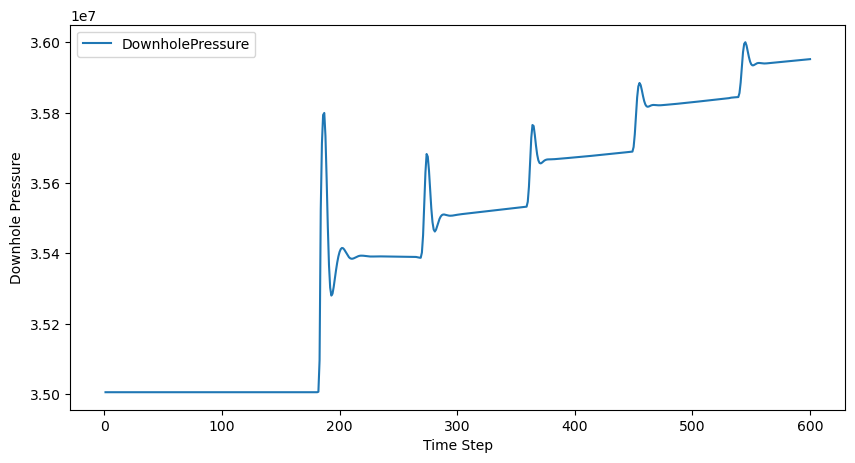

In [9]:
# Plot DownholePressure against time step
plt.figure(figsize=(10,5))
plt.plot(range(1, 601), df['DownholePressure'], label='DownholePressure')
plt.xlabel('Time Step')
plt.ylabel('Downhole Pressure')
plt.legend()
plt.show()

### Save the data to preferred folder 

In [ ]:
pwd

In [ ]:
import os
import subprocess
import datetime
import pandas as pd

# specify the full path to the folder where the file is saved
folder_path = "/Users/

# specify the simulation identifier used to save the file
simulation_id = "validation"

# specify the current date and time as a string
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H")

# create the folder if it does not exist
os.makedirs(folder_path, exist_ok=True)

# construct the full path to the CSV file to write
file_name = f"results_{simulation_id}_{current_time}.csv"
file_path = os.path.join(folder_path, file_name)

# write the DataFrame to a CSV file
df.to_csv(file_path, index=False)

# read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# open the CSV file using the default program associated with CSV files
if os.name == 'nt':  # for Windows
    os.startfile(file_path)
else:  # for Mac and Linux
    subprocess.call(('open', file_path))
